# Baseline implementation for application 

Note:
- We use LightGBM as opposed to other libraries such as XGBoost as it handles categorical features better if they have a high number of categories (application of _On Grouping for Maximum Homogeneity_)
- We run Classification and Regression on the same dataset to illustrate the use

In [54]:
import numpy as np
import pandas as pd

# Model and metrics
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# viz
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
%load_ext autoreload
%autoreload 2
from main.fairness.wasserstein import WassersteinFairRegression
from main.utils.preprocessing import preprocess_census
from main.estimators.evaluation import cv_early_stopping
from main.fairness.metrics import unfairness

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare data

Recall the definitions of the variables:
- MAR: Marital status
- OCCP: Occupation recode for 2018 and later based on 2018 OCC codes
- POBP: Place of birth (Recode)
- PINCP: Total person's income (signed, use ADJINC to adjust to constant dollars)
- AGEP: Age
- COW: Class of worker (state, self-employed)
- SEX: Gender
- WKHP: Usual hours worked per week past 12 months
- RELP:  Relationship - Grandkid etc.
- RAC1P: Recoded detailed race code 
- SCHL: Educational attainment

In [49]:
data_all = pd.read_csv('data/prepared/usage_data_sunbelt.csv')

In [50]:
cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

ret_dict =  preprocess_census(data=data_all,
                              target_feature='PINCP',
                              sensitive_features=['SEX', 'RAC1P'],
                              categorical_features=cat_features,
                              continuous_features=['WKHP', 'AGEP'])

In [6]:
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1
}

In [7]:
%%capture
cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=ret_dict['X_train'], 
                               y_train=ret_dict['y_train'], 
                               categorical_feats=cat_features)

In [8]:
best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

Best MSE: 0.5646566256682791 
Best Iter: 182


In [9]:
# Retrain whole model
data_train_all = lgb.Dataset(data=ret_dict['X_train'], 
                             label=ret_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)

In [52]:
best_estimator.save_model('data/models/baseline_model.txt')

In [10]:
fairness_regressor = WassersteinFairRegression(best_estimator)
fairness_regressor.fit(ret_dict['X_calib'], sensitive_name='SEX_2')

In [41]:
semifair_preds = fairness_regressor.predict(ret_dict['X_test'], sensitive_name='SEX_2', epsilon=0.75)
fair_preds = fairness_regressor.predict(ret_dict['X_test'], sensitive_name='SEX_2')

In [42]:
var_key = np.where(ret_dict['X_train'].columns == 'SEX_2')[0][0]

In [43]:
mean_squared_error(ret_dict['y_test'], fairness_regressor.y_pred[var_key])

0.5777328091175477

In [44]:
a_ = fair_preds[np.where(ret_dict['sens_SEX_test'] == 1)[0]]
b_ = fair_preds[np.where(ret_dict['sens_SEX_test'] == 0)[0]]

In [45]:
unfairness(a_, b_)

0.01928447920782972

In [46]:
mean_squared_error(ret_dict['y_test'], fair_preds)

0.5898576145084405

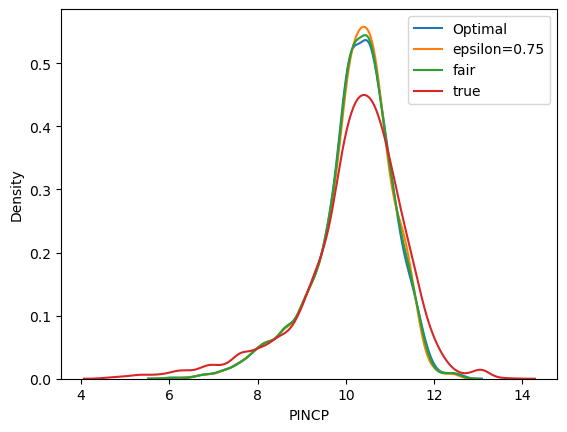

In [48]:
sns.kdeplot(fairness_regressor.y_pred[var_key], label='Optimal')
sns.kdeplot(fair_preds, label='epsilon=0.75')
sns.kdeplot(semifair_preds, label='fair')
sns.kdeplot(ret_dict['y_test'], label='true')
plt.legend()